In [4]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from itertools import combinations
from scipy import stats

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing

from news_vec.corpus import Corpus

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
corpus = Corpus('../data/clf-headlines.json/')

2018-12-29 09:29:05,709 | INFO : Reading headlines.
1225511it [00:17, 71689.49it/s]


In [65]:
def pred_ab(d1, d2):
    
    df = corpus.sample_ab(d1, d2)

    tv = TfidfVectorizer(
        analyzer='word',
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None,
        ngram_range=(1,3)
    )

    df_train, df_test = train_test_split(df)

    X_train = tv.fit_transform(df_train.clf_tokens)
    X_test = tv.transform(df_test.clf_tokens)

    clf = LogisticRegression(solver='lbfgs')
    fit = clf.fit(X_train, df_train.domain)

    df_test = df_test.copy()
    
    df_test['p_true'] = [
        p[0] if d==fit.classes_[0] else p[1]
        for p, d in zip(fit.predict_proba(X_test), df_test.domain)
    ]
    
    df_test['p_false'] = 1 - df_test.p_true
    
    return df_test

In [66]:
def pt_imp_corr(pred_df, domain, max_imp_rank=1):
    
    df = pred_df[pred_df.domain==domain].copy()
    df['imp_rank'] = df.impressions.rank(pct=True)
    df = df[df.imp_rank < max_imp_rank]

    df['log_imp'] = np.log(df.impressions)
    
    corr, p = stats.pearsonr(df.p_false, df.log_imp)

    return corr, p, df

In [101]:
def plot_sl(d1, d2):
    
    pred_df = pred_ab(d1, d2)
    corr, p, ddf = pt_imp_corr(pred_df, d1)
    
    plt.figure(figsize=(10,5))
    
    print(corr, p)
    
    sns.jointplot(
        y='log_imp',
        x='p_false',
        data=ddf,
        height=10,
        kind='reg',
        scatter_kws=dict(s=1),
    )

# As outlet A -> B, what happens to impressions?

0.14191041230563553 1.7372103819545952e-31


<Figure size 720x360 with 0 Axes>

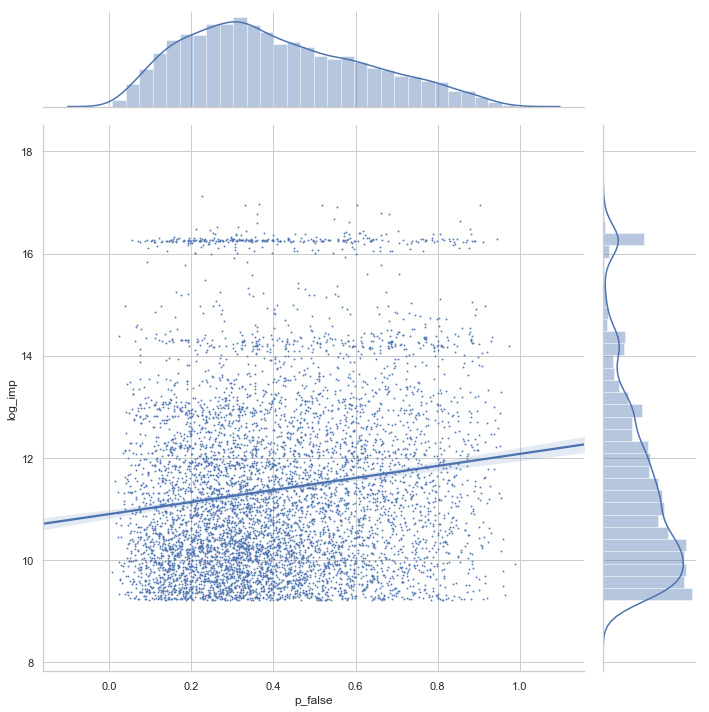

In [102]:
plot_sl('huffingtonpost.com', 'dailykos.com')

0.1287118130295637 2.5915229202941114e-26


<Figure size 720x360 with 0 Axes>

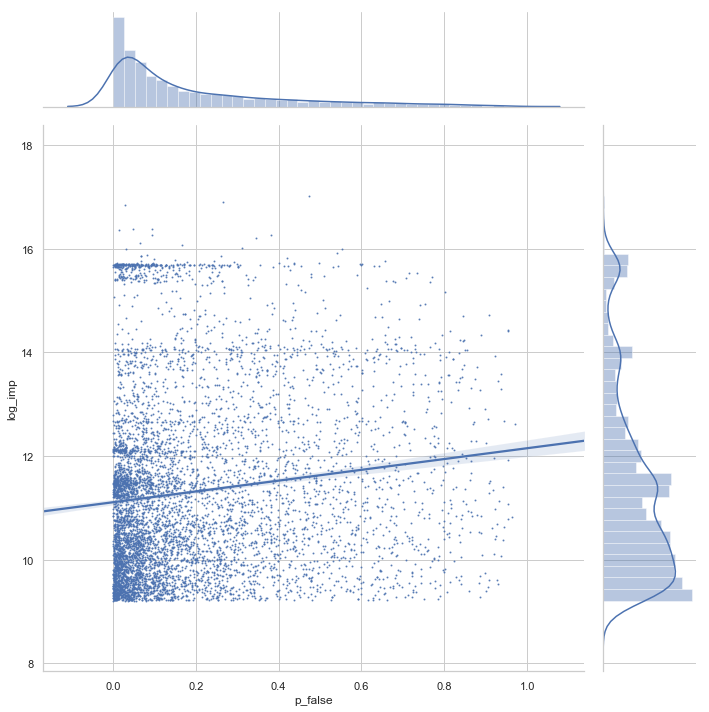

In [103]:
plot_sl('buzzfeed.com', 'dailycaller.com')

-0.12357083287820475 3.4904156576942286e-24


<Figure size 720x360 with 0 Axes>

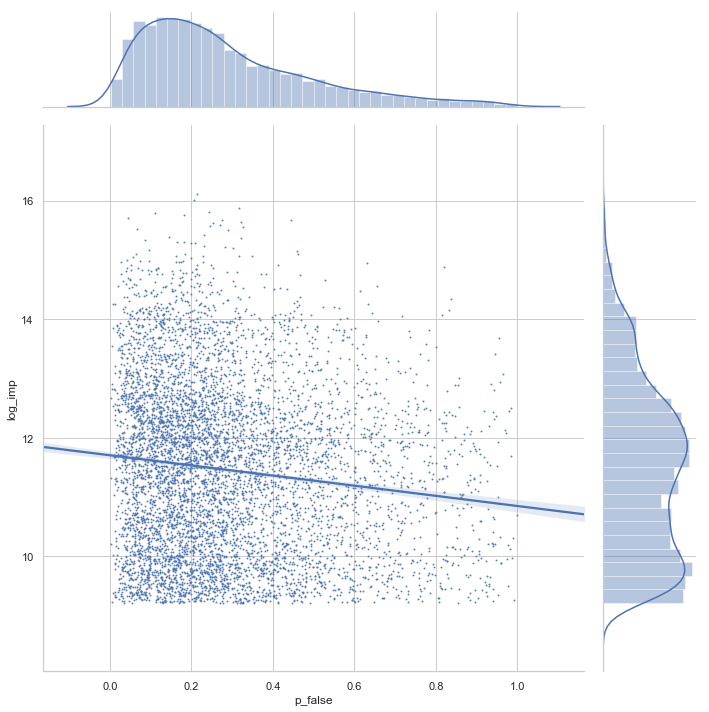

In [104]:
plot_sl('breitbart.com', 'sputniknews.com')

0.002126908578990509 0.8617039114208636


<Figure size 720x360 with 0 Axes>

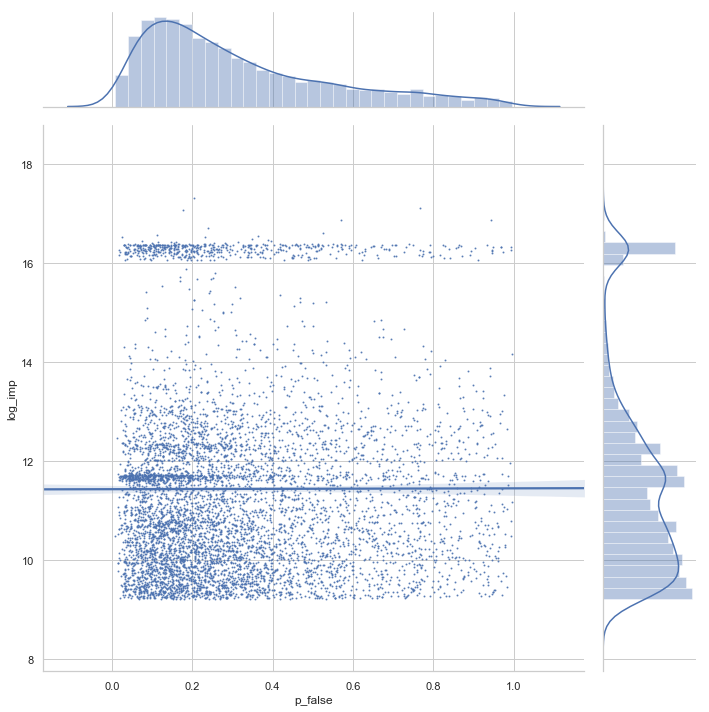

In [105]:
plot_sl('apnews.com', 'dailykos.com')

0.152748985334373 2.618554296926109e-36


<Figure size 720x360 with 0 Axes>

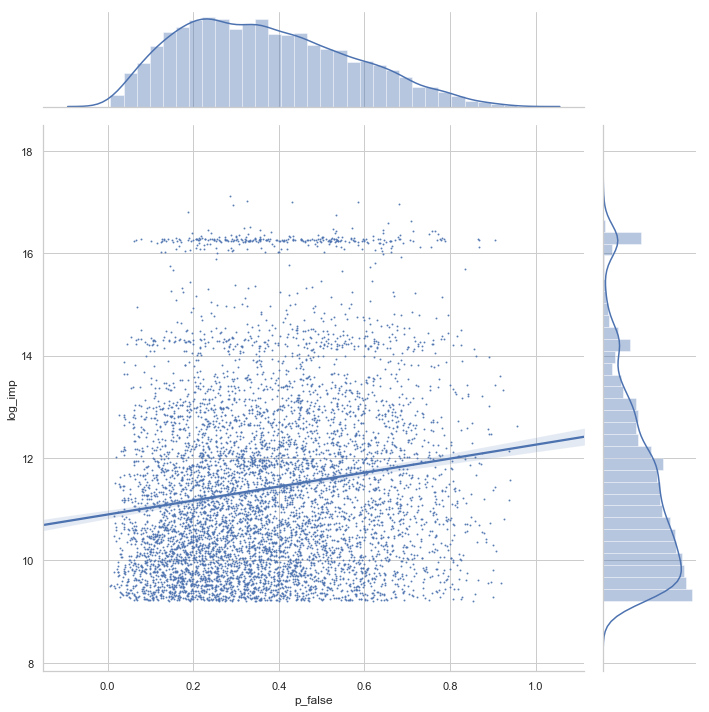

In [106]:
plot_sl('huffingtonpost.com', 'dailycaller.com')

In [91]:
domains = corpus.df.domain.unique()

In [92]:
pairs = list(combinations(domains, 2))

In [ ]:
rows = []
for d1, d2 in tqdm(pairs):
    pred_df = pred_ab(d1, d2)
    corr1, p1, _ = pt_imp_corr(pred_df, d1)
    corr2, p2, _ = pt_imp_corr(pred_df, d2)
    rows.append((d1, d2, corr1, p1))
    rows.append((d2, d1, corr2, p2))

In [94]:
df = pd.DataFrame(rows, columns=('d1', 'd2', 'corr', 'p'))

In [95]:
df['label'] = df.apply(lambda r: f'{r.d1} -> {r.d2}', 1)

# A -> B for all outlet permutations

HuffPo and Buzzfeed are highly "unoptimized"; conservative outlets are penalized for leaving their lane.

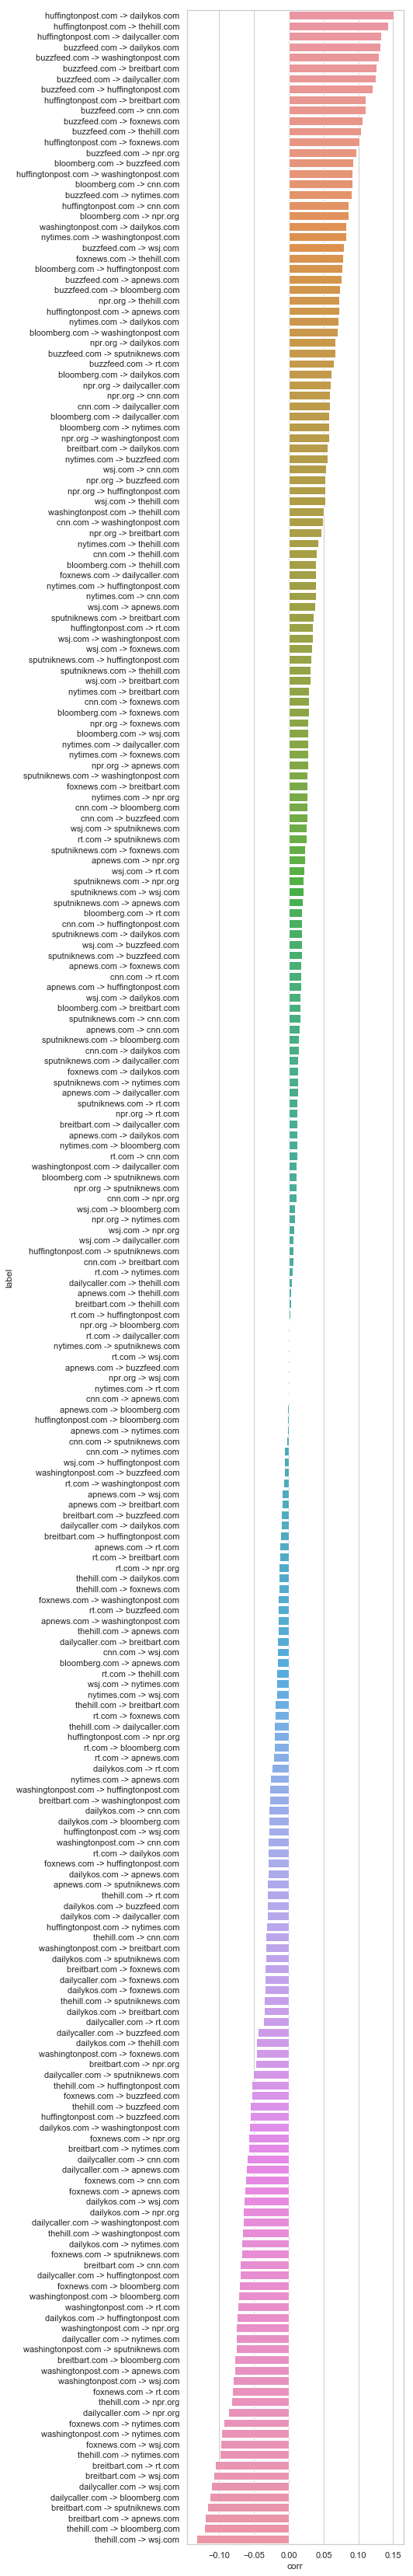

In [96]:
plt.figure(figsize=(5,60))
sns.barplot(x='corr', y='label', data=df.sort_values('corr', ascending=False))

In [111]:
df.groupby('d1').mean().sort_values('corr', ascending=False)

,corr,p
d1,,
buzzfeed.com,0.100149,1.222229e-08
huffingtonpost.com,0.052579,1.021949e-01
bloomberg.com,0.048114,5.736807e-02
npr.org,0.037223,2.047024e-01
nytimes.com,0.027179,1.653262e-01
wsj.com,0.021771,1.760963e-01
sputniknews.com,0.021464,1.223396e-01
cnn.com,0.018135,2.704667e-01
apnews.com,0.001276,3.883442e-01


In [112]:
df.groupby('d1').corr.max().sort_values(ascending=False)

d1
huffingtonpost.com    0.150687
buzzfeed.com          0.131830
bloomberg.com         0.092723
washingtonpost.com    0.082627
nytimes.com           0.082349
foxnews.com           0.078506
npr.org               0.072882
cnn.com               0.058689
breitbart.com         0.055595
wsj.com               0.054165
sputniknews.com       0.035490
rt.com                0.025301
apnews.com            0.023511
dailycaller.com       0.005065
thehill.com          -0.014306
dailykos.com         -0.023948
Name: corr, dtype: float64

In [113]:
df.groupby('d1').corr.min().sort_values(ascending=True)

d1
thehill.com          -0.132200
breitbart.com        -0.120847
dailycaller.com      -0.113995
foxnews.com          -0.097693
washingtonpost.com   -0.096758
dailykos.com         -0.074459
huffingtonpost.com   -0.056153
apnews.com           -0.030835
rt.com               -0.029781
nytimes.com          -0.026364
wsj.com              -0.017777
bloomberg.com        -0.016566
cnn.com              -0.016280
npr.org              -0.000944
sputniknews.com       0.012901
buzzfeed.com          0.064359
Name: corr, dtype: float64

# TODO: Rank -> d2

# Left / right

What if we group together left/right outlets?

In [110]:
ava_df = corpus.sample_all_vs_all()

In [119]:
LEFT = {'nytimes.com', 'huffingtonpost.com', 'dailykos.com'}
RIGHT = {'foxnews.com', 'breitbart.com', 'dailycaller.com'}

In [126]:
ava_df = ava_df[ava_df.domain.isin(LEFT | RIGHT)].copy()
ava_df['lr'] = ava_df.domain.apply(lambda d: 'left' if d in LEFT else 'right', 1)

In [135]:
tv = TfidfVectorizer(
    analyzer='word',
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None,
    ngram_range=(1,3)
)

df_train, df_test = train_test_split(ava_df)

X_train = tv.fit_transform(df_train.clf_tokens)
X_test = tv.transform(df_test.clf_tokens)

clf = LogisticRegression(solver='lbfgs', verbose=True)
fit = clf.fit(X_train, df_train.lr)

df_test = df_test.copy()

df_test['p_true'] = [
    p[0] if d==fit.classes_[0] else p[1]
    for p, d in zip(fit.predict_proba(X_test), df_test.lr)
]

df_test['p_false'] = 1 - df_test.p_true

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/dclure/.local/share/virtualenvs/news-vec-AvAtlVxK/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.8s finished


In [136]:
len(df_test[df_test.p_true>0.5]) / len(df_test)

0.7576569868453711

Left is slightly rewarded for moving right; right is (more) penalized for moving left.

0.030308966840280158 1.727843919194746e-05


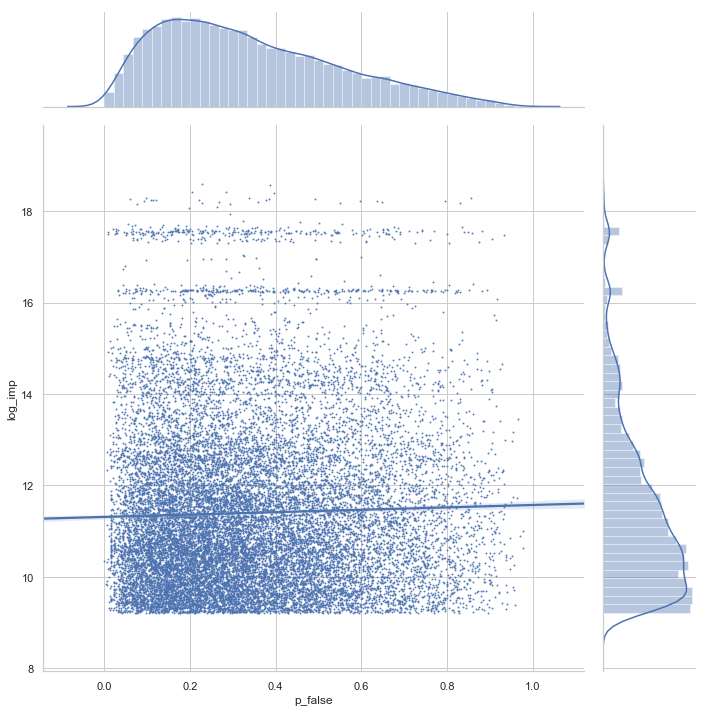

In [154]:
df_lr = df_test[df_test.lr=='left'].copy()
df_lr['imp_rank'] = df_lr.impressions.rank(pct=True)
df_lr = df_lr[df_lr.imp_rank < 1]
df_lr['log_imp'] = np.log(df_lr.impressions)

corr, p = stats.pearsonr(df_lr.p_false, df_lr.log_imp)
print(corr, p)

sns.jointplot(
    y='log_imp',
    x='p_false',
    data=df_lr,
    height=10,
    kind='reg',
    scatter_kws=dict(s=1),
)

-0.053569044809573474 2.5985400582743222e-14


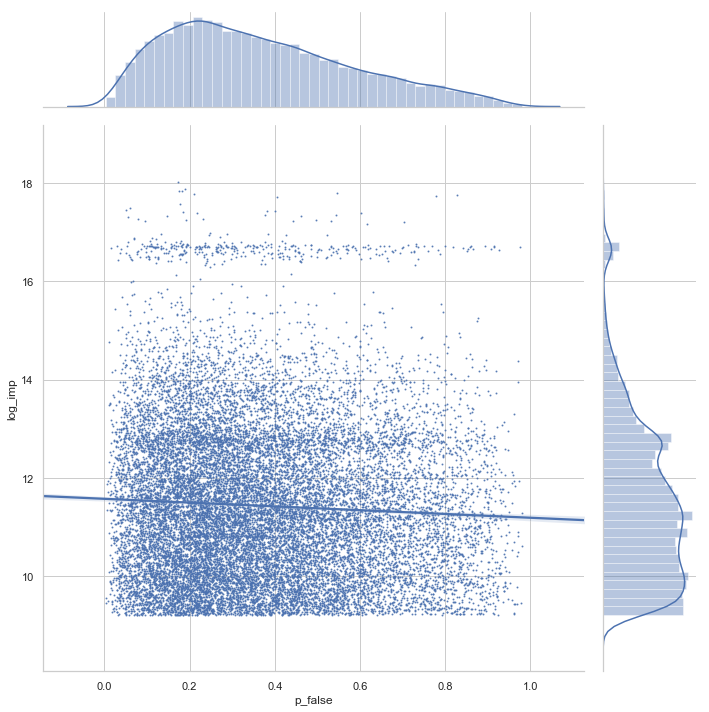

In [155]:
df_lr = df_test[df_test.lr=='right'].copy()
df_lr['imp_rank'] = df_lr.impressions.rank(pct=True)
df_lr = df_lr[df_lr.imp_rank < 1]
df_lr['log_imp'] = np.log(df_lr.impressions)

corr, p = stats.pearsonr(df_lr.p_false, df_lr.log_imp)
print(corr, p)

sns.jointplot(
    y='log_imp',
    x='p_false',
    data=df_lr,
    height=10,
    kind='reg',
    scatter_kws=dict(s=1),
)